/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


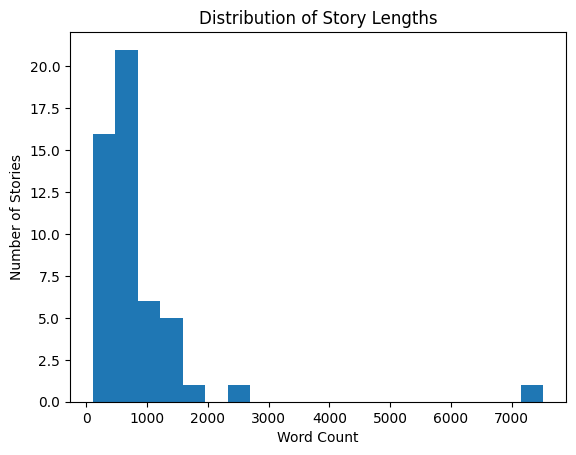

   story_id                                      title  \
0         1  The Coming of Men, A Long, Long While Ago   
1         2  Nukúnguasik, Who Escaped from the Tupilak   
2         3                                Qujâvârssuk   

                                                text  text_length  \
0  Our forefathers have told us much of the comin...          670   
1  Nukúnguasik, it is said, had land in a place w...          469   
2  A strong man had land at Ikerssuaq. The only o...         7521   

                                          clean_text  
0  Our forefathers have told us much of the comin...  
1  Nukúnguasik, it is said, had land in a place w...  
2  A strong man had land at Ikerssuaq. The only o...  
Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities:
  entity_candidate entity
0            Ailaq    PER
1             Aluk    PER
2           Alátaq    PER
3         Amerdloq  

Map: 100%|██████████| 409/409 [00:00<00:00, 18635.07 examples/s]


Processed datasets ready for training.


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_11432/2554446986.py:311: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [ ]:
# =========================
# 1. SETUP & IMPORTS
# =========================

import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # Allow up to 90% of MPS memory
import torch


import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from transformers import (
    pipeline, AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('words')

# =========================
# 2. LOAD & EXPLORE FOLKTALES DATA
# =========================

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

# =========================
# 3. CLEAN THE TEXT
# =========================

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print(df.head(3))

# =========================
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
# =========================

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

# =========================
# 5. LOAD MANUALLY CURATED CANDIDATE CSV AND MERGE WITH SCRAPED DATA
# =========================

# Attempt to load your manually curated candidate CSV.
# The CSV should have columns: "entity_candidate" and "entity"
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    manual_dict = dict(zip(manual_df["entity_candidate"].str.lower(), manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

# Merge: manual data takes precedence; add scraped names and towns if not already present.
entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.lower()
    if key not in entity_dict:
        entity_dict[key] = "PER"  # Default scraped personal names as PER
for town in scraped_towns:
    key = town.lower()
    if key not in entity_dict:
        entity_dict[key] = "LOC"  # Default scraped town names as LOC

print("Final Entity Dictionary (sample):")
for key, val in list(entity_dict.items())[:20]:
    print(f"{key}: {val}")

# =========================
# 6. AUTO-LABEL FOLKTALE TEXTS USING THE ENTITY DICTIONARY
# =========================

def get_entity_label(token, entity_dict):
    token_lower = token.lower()
    if token_lower in entity_dict:
        return entity_dict[token_lower]
    elif token_lower.endswith("s"):  # Simple plural normalization
        return entity_dict.get(token_lower[:-1], "O")
    else:
        return "O"

def auto_label_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        for token in tokens:
            ner_label = get_entity_label(token, entity_dict)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": ner_label
            })
    return data_rows

all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    labeled_tokens = auto_label_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
print("Auto-labeled DataFrame size:", auto_ner_df.shape)
print(auto_ner_df.head(20))

# Optionally, save the auto-labeled data for review
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

# =========================
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING
# =========================

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })

df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

# Split into train/validation sets (80/20 split)
train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

# =========================
# 8. PREPARE DATA FOR TRAINING: TOKENIZATION & LABEL ALIGNMENT
# =========================

# Define your label list – update with your custom labels as needed.
label_list = ["O", "PER", "LOC", "SPI", "MON"]  # Example: add more as needed.
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"  # Multilingual model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            else:
                aligned_labels.append(label2id.get(example_labels[word_id], 0))
        all_labels.append(aligned_labels)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)
print("Processed datasets ready for training.")

# =========================
# 9. TRAIN THE CUSTOM NER MODEL
# =========================

# Load evaluation metric
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_labels = []
    true_preds = []
    for pred_row, label_row in zip(predictions, labels):
        temp_true_labels = []
        temp_true_preds = []
        for p_i, l_i in zip(pred_row, label_row):
            if l_i == -100:
                continue
            temp_true_labels.append(id2label[l_i])
            temp_true_preds.append(id2label[p_i])
        if temp_true_labels:
            true_labels.append(temp_true_labels)
            true_preds.append(temp_true_preds)
    
    if len(true_labels) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    
    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results.get("overall_precision", 0.0),
        "recall": results.get("overall_recall", 0.0),
        "f1": results.get("overall_f1", 0.0),
        "accuracy": results.get("overall_accuracy", 1.0)
    }

data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
model.gradient_checkpointing_enable()  # Reduce memory usage

training_args = TrainingArguments(
    output_dir="greenlandic_ner_checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    logging_steps=50,
    # fp16=True  # Mixed precision training if supported
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_datasets["train"],
    eval_dataset=processed_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("greenlandic_ner_model")
tokenizer.save_pretrained("greenlandic_ner_model")

# =========================
# 10. INFERENCE
# =========================

from transformers import pipeline
ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model",
    tokenizer="greenlandic_ner_model",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("Inference output:")
print(ner_infer(test_text))